### Import de librerias

In [2]:

%matplotlib inline 
import matplotlib.pyplot as plt 

import numpy as np ; np.random.seed(sum(map(ord, "aesthetics")))
import pandas as pd



from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import ShuffleSplit,train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler


import seaborn 
seaborn.set_context('notebook') 
seaborn.set_style(style='darkgrid')

from pprint import pprint 
 


### Funciones de evaluacion

Son funciones que no vienen prorccionadas por el paquete scikit learn

In [105]:
# Function for evaluation reports
def get_eval(clf, X,y):

    scores1 = cross_val_score(clf, X, y, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X, y, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X, y, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X, y, cv=2, scoring='roc_auc')
    
    # La media de los scores anteriores y su desviacion
    print("Validacion cruzada: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Validacion cruzada: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Validacion cruzada: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Validacion cruzada: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return 

def get_eval2(clf, X_train, y_train,X_test, y_test):
    # Aqui hago cross balidation para prevenir el overfitting.
    scores1 = cross_val_score(clf, X_test, y_test, cv=2, scoring='accuracy')
    scores2 = cross_val_score(clf, X_test, y_test, cv=2, scoring='precision')
    scores3 = cross_val_score(clf, X_test, y_test, cv=2, scoring='recall')
    scores4 = cross_val_score(clf, X_test, y_test, cv=2, scoring='roc_auc')
    
    # La media de los scores anteriores y su desviacion tipica.En clase se utilizaba boxplots para representarlo
    # yo utilizo un metodo mas numerico.
    print("Validacion cruzada Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Validacion cruzada Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Validacion cruzadaRecall: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    print("Validacion cruzada roc_auc: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std()))
    
    return  
  
# Funcion que da la curva ROC
def get_roc (y_test,y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='Curva ROC (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Ranking de falsos positivos')
    plt.ylabel('Ranking de vardaros positivos')
    plt.legend(loc="upper left")
    plt.show()
    return


#### XGBoost Model

In [83]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import xgboost as xgb
from xgboost import XGBClassifier
#print('XGBoost v',xgb.__version__)

def xgbclf(params, X_train, y_train,X_test, y_test):
  
    eval_set=[(X_train, y_train), (X_test, y_test)]
    
    model = XGBClassifier(**params).\
      fit(X_train, y_train, eval_set=eval_set, \
                  eval_metric='auc', early_stopping_rounds = 100, verbose=100)
        
  
    model.set_params(**{'n_estimators': model.best_ntree_limit})
    model.fit(X_train, y_train)
    #print(model,'\n')
    
    # Prediccion de la variable objetivo.
    y_pred = model.predict(X_test, ntree_limit=model.best_ntree_limit) 
   
    # Hacer la crooss validation
    get_eval(model, X_train, y_train)
    get_eval2(model, X_train, y_train,X_test, y_test)
    
    # Creacion de martiz de confusion  
    abclf_cm = confusion_matrix(y_test,y_pred)
    print(abclf_cm)
    
    #y_pred = model.predict(X_test)
    print (classification_report(y_test,y_pred) )
    print ('\n')
    print ("Modelo final con Accuracy: %.6f" %accuracy_score(y_test,y_pred) )
    
    # Predecir las variables
    y_pred_proba = model.predict_proba(X_test, ntree_limit=model.best_ntree_limit)[:,1] #model.best_iteration
    get_roc (y_test,y_pred_proba)
    return model

def plot_featureImportance(model, keys):
  importances = model.feature_importances_

  importance_frame = pd.DataFrame({'Importance': list(importances), 'Feature': list(keys)})
  importance_frame.sort_values(by = 'Importance', inplace = True)
  importance_frame.tail(10).plot(kind = 'barh', x = 'Feature', figsize = (8,8), color = 'orange')




In [28]:
file = 'data/germancreditdata/german.data'

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']

data = pd.read_csv(file,names = names, delimiter=' ')
print(data.shape)
print (data.columns)
data.head(10)

(1000, 21)
Index(['existingchecking', 'duration', 'credithistory', 'purpose',
       'creditamount', 'savings', 'employmentsince', 'installmentrate',
       'statussex', 'otherdebtors', 'residencesince', 'property', 'age',
       'otherinstallmentplans', 'housing', 'existingcredits', 'job',
       'peopleliable', 'telephone', 'foreignworker', 'classification'],
      dtype='object')


,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [29]:

data.classification.replace([1,2], [1,0], inplace=True)

## 300 es un buen credito menos de 300 es malo

data.classification.value_counts()

1    700
0    300
Name: classification, dtype: int64

### StandardScaler

In [30]:
#variables numericas


numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable', 'classification']

# Standardization
numdata_std = pd.DataFrame(StandardScaler().fit_transform(data[numvars].drop(['classification'], axis=1)))

### Variables categoricas 

Transformamos las variables categoricas a variables que puedan ser interpretadas por el programa con la funcion get dummies.

In [31]:
from collections import defaultdict

# Variables que son categoricas
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']

d = defaultdict(LabelEncoder)

# C
lecatdata = data[catvars].apply(lambda x: d[x.name].fit_transform(x))


for x in range(len(catvars)):
    print(catvars[x],": ", data[catvars[x]].unique())
    print(catvars[x],": ", lecatdata[catvars[x]].unique())


dummyvars = pd.get_dummies(data[catvars])



existingchecking :  ['A11' 'A12' 'A14' 'A13']
existingchecking :  [0 1 3 2]
credithistory :  ['A34' 'A32' 'A33' 'A30' 'A31']
credithistory :  [4 2 3 0 1]
purpose :  ['A43' 'A46' 'A42' 'A40' 'A41' 'A49' 'A44' 'A45' 'A410' 'A48']
purpose :  [4 7 3 0 1 9 5 6 2 8]
savings :  ['A65' 'A61' 'A63' 'A64' 'A62']
savings :  [4 0 2 3 1]
employmentsince :  ['A75' 'A73' 'A74' 'A71' 'A72']
employmentsince :  [4 2 3 0 1]
statussex :  ['A93' 'A92' 'A91' 'A94']
statussex :  [2 1 0 3]
otherdebtors :  ['A101' 'A103' 'A102']
otherdebtors :  [0 2 1]
property :  ['A121' 'A122' 'A124' 'A123']
property :  [0 1 3 2]
otherinstallmentplans :  ['A143' 'A141' 'A142']
otherinstallmentplans :  [2 0 1]
housing :  ['A152' 'A153' 'A151']
housing :  [1 2 0]
job :  ['A173' 'A172' 'A174' 'A171']
job :  [2 1 3 0]
telephone :  ['A192' 'A191']
telephone :  [1 0]
foreignworker :  ['A201' 'A202']
foreignworker :  [0 1]


In [32]:
data_clean = pd.concat([data[numvars], dummyvars], axis = 1)

print(data_clean.shape)

(1000, 62)


### Dividimos el daset en train and clean

In [33]:
X_clean = data_clean.drop('classification', axis=1)
y_clean = data_clean['classification']
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean,y_clean,test_size=0.2, random_state=1)

In [34]:
X_train_clean.keys()

Index(['creditamount', 'duration', 'installmentrate', 'residencesince', 'age',
       'existingcredits', 'peopleliable', 'existingchecking_A11',
       'existingchecking_A12', 'existingchecking_A13', 'existingchecking_A14',
       'credithistory_A30', 'credithistory_A31', 'credithistory_A32',
       'credithistory_A33', 'credithistory_A34', 'purpose_A40', 'purpose_A41',
       'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44',
       'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49',
       'savings_A61', 'savings_A62', 'savings_A63', 'savings_A64',
       'savings_A65', 'employmentsince_A71', 'employmentsince_A72',
       'employmentsince_A73', 'employmentsince_A74', 'employmentsince_A75',
       'statussex_A91', 'statussex_A92', 'statussex_A93', 'statussex_A94',
       'otherdebtors_A101', 'otherdebtors_A102', 'otherdebtors_A103',
       'property_A121', 'property_A122', 'property_A123', 'property_A124',
       'otherinstallmentplans_A141', 'otherinstallmentplans_A

### XGBoost  

[0]	validation_0-auc:0.761589	validation_1-auc:0.692451
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[99]	validation_0-auc:0.947201	validation_1-auc:0.735064
Validacion cruzada: 0.74 (+/- 0.01)
Validacion cruzada: 0.78 (+/- 0.01)
Validacion cruzada: 0.87 (+/- 0.00)
Validacion cruzada: 0.77 (+/- 0.00)
Validacion cruzada Accuracy: 0.72 (+/- 0.03)
Validacion cruzada Precision: 0.78 (+/- 0.00)
Validacion cruzadaRecall: 0.84 (+/- 0.05)
Validacion cruzada roc_auc: 0.71 (+/- 0.02)
[[ 24  35]
 [ 13 128]]
              precision    recall  f1-score   support

           0       0.65      0.41      0.50        59
           1       0.79      0.91      0.84       141

    accuracy                           0.76       200
   macro avg       0.72      0.66      0.67       200
weighted avg       0.74      0.76      0.74       200



Modelo final con Accuracy: 0.760000


/home/xus/PycharmProjects/machine-learning/venv/lib/python3.5/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "Arriva izquierda". Falling back on "best"; valid locations are
	center right
	upper center
	lower right
	upper right
	center
	lower left
	upper left
	best
	lower center
	right
	center left

  % (loc, '\n\t'.join(self.codes)))


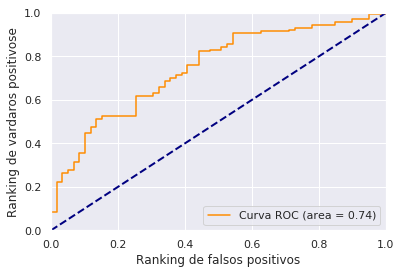

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=51, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [84]:
params={}
xgbclf(params, X_train_clean, y_train_clean, X_test_clean, y_test_clean)

### XGBoost  1

[0]	validation_0-auc:0.788664	validation_1-auc:0.708258
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.893809	validation_1-auc:0.780803
Stopping. Best iteration:
[9]	validation_0-auc:0.873373	validation_1-auc:0.785611

Validacion cruzada: 0.75 (+/- 0.00)
Validacion cruzada: 0.76 (+/- 0.00)
Validacion cruzada: 0.93 (+/- 0.01)
Validacion cruzada: 0.75 (+/- 0.00)
Validacion cruzada Accuracy: 0.73 (+/- 0.02)
Validacion cruzada Precision: 0.72 (+/- 0.01)
Validacion cruzadaRecall: 1.00 (+/- 0.00)
Validacion cruzada roc_auc: 0.67 (+/- 0.02)
[[ 23  36]
 [  5 136]]
              precision    recall  f1-score   support

           0       0.82      0.39      0.53        59
           1       0.79      0.96      0.87       141

    accuracy                           0.80       200
   macro avg       0.81      0.68      0.70       200
weighted avg       0.80      

/home/xus/PycharmProjects/machine-learning/venv/lib/python3.5/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "Arriva izquierda". Falling back on "best"; valid locations are
	center right
	upper center
	lower right
	upper right
	center
	lower left
	upper left
	best
	lower center
	right
	center left

  % (loc, '\n\t'.join(self.codes)))


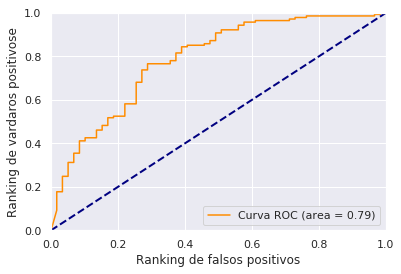

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.005, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=None, n_estimators=10, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.555, verbosity=1)

In [85]:
params={}

params1={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':3,
    #'seed':1024,
    'n_jobs' : -1
}

params2={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.005,
    #'gamma':0.01,
    'subsample':0.555,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'max_depth':8,
    #'seed':1024,
    'n_jobs' : -1
}

xgbclf(params2, X_train_clean, y_train_clean, X_test_clean, y_test_clean)

<a id="Dataset"></a> <br>


In [86]:

from imblearn.over_sampling import SMOTE

# Hacempos ooversampling
# http://contrib.scikit-learn.org/imbalanced-learn/auto_examples/combine/plot_smote_enn.html#sphx-glr-auto-examples-combine-plot-smote-enn-py

sm = SMOTE(ratio='auto')
X_train_clean_res, y_train_clean_res = sm.fit_sample(X_train_clean, y_train_clean)

# Lo que hacemos ahora es corregir el problema de que no hay el mismo numero de buenos y malos.Para corregir eso hacemos
# oversampling.
print("Antes/Despues de la limpieza ")
unique, counts = np.unique(y_train_clean, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_clean_res, return_counts=True)
print(dict(zip(unique, counts)))

Antes/Despues de la limpieza 
{0: 241, 1: 559}
{0: 559, 1: 559}


In [87]:
# Separamos los datos en train y dataset
X_train_clean_res = pd.DataFrame(X_train_clean_res, columns=X_train_clean.keys())


In [88]:
print(np.shape(X_train_clean_res))
print(np.shape(y_train_clean_res))
print(np.shape(X_test_clean)) 
print(np.shape(y_test_clean))

(1118, 61)
(1118,)
(200, 61)
(200,)


### XGBoost 2

[0]	validation_0-auc:0.818509	validation_1-auc:0.687823
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[99]	validation_0-auc:0.970968	validation_1-auc:0.748648
Validacion cruzada: 0.75 (+/- 0.08)
Validacion cruzada: 0.80 (+/- 0.19)
Validacion cruzada: 0.80 (+/- 0.13)
Validacion cruzada: 0.87 (+/- 0.08)
Validacion cruzada Accuracy: 0.73 (+/- 0.02)
Validacion cruzada Precision: 0.78 (+/- 0.00)
Validacion cruzadaRecall: 0.85 (+/- 0.05)
Validacion cruzada roc_auc: 0.72 (+/- 0.01)
[[ 31  28]
 [ 27 114]]
              precision    recall  f1-score   support

           0       0.53      0.53      0.53        59
           1       0.80      0.81      0.81       141

    accuracy                           0.73       200
   macro avg       0.67      0.67      0.67       200
weighted avg       0.72      0.72      0.72       200



Modelo final con Accuracy: 0.725000


/home/xus/PycharmProjects/machine-learning/venv/lib/python3.5/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "Arriva izquierda". Falling back on "best"; valid locations are
	center right
	upper center
	lower right
	upper right
	center
	lower left
	upper left
	best
	lower center
	right
	center left

  % (loc, '\n\t'.join(self.codes)))


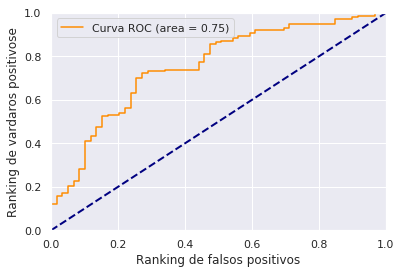

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=31, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [89]:
# modelo base
params={}
xgbclf(params,X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### XGBoost 2b: 

[0]	validation_0-auc:0.851281	validation_1-auc:0.618824
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.949904	validation_1-auc:0.779781
Stopping. Best iteration:
[51]	validation_0-auc:0.947467	validation_1-auc:0.783387

Validacion cruzada: 0.75 (+/- 0.07)
Validacion cruzada: 0.80 (+/- 0.17)
Validacion cruzada: 0.79 (+/- 0.13)
Validacion cruzada: 0.87 (+/- 0.08)
Validacion cruzada Accuracy: 0.73 (+/- 0.00)
Validacion cruzada Precision: 0.72 (+/- 0.00)
Validacion cruzadaRecall: 0.99 (+/- 0.01)
Validacion cruzada roc_auc: 0.70 (+/- 0.02)
[[ 29  30]
 [ 15 126]]
              precision    recall  f1-score   support

           0       0.66      0.49      0.56        59
           1       0.81      0.89      0.85       141

    accuracy                           0.78       200
   macro avg       0.73      0.69      0.71       200
weighted avg       0.76     

/home/xus/PycharmProjects/machine-learning/venv/lib/python3.5/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "Arriva izquierda". Falling back on "best"; valid locations are
	center right
	upper center
	lower right
	upper right
	center
	lower left
	upper left
	best
	lower center
	right
	center left

  % (loc, '\n\t'.join(self.codes)))


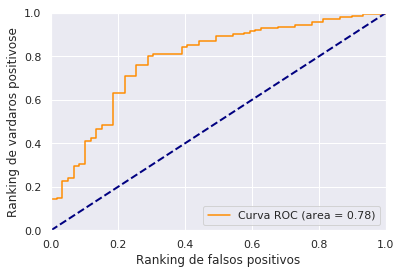

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.005, max_delta_step=0, max_depth=8,
              min_child_weight=3, missing=None, n_estimators=52, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.555, verbosity=1)

In [90]:
params = {}

params1={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.05,
    'gamma':0.1,
    'subsample':0.8,
    'colsample_bytree':0.3,
    'min_child_weight':3,
    'max_depth':3,
    #'seed':1024,
    'n_jobs' : -1
}

params2={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.005,
    #'gamma':0.01,
    'subsample':0.555,
    'colsample_bytree':0.7,
    'min_child_weight':3,
    'max_depth':8,
    #'seed':1024,
    'n_jobs' : -1
}

#xgbclf(params, X_train, y_train,X_test,y_test)
model = xgbclf(params2,X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)
model


# 4.  Selccion de variables
- XGBoost3 Modelo base
- GridSearchCV 

In [91]:
#model = xgbclf(params1,X_train_clean_res[importance_col], y_train_clean_res,X_test_clean[importance_col], y_test_clean)

importances = model.feature_importances_
importance_frame = pd.DataFrame({'Importance': list(importances), 'Feature': list(X_train_clean_res.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True, ascending=False)
importance_col = importance_frame.Feature.head(10).values

### XGBoost3 Modelo base

[0]	validation_0-auc:0.811014	validation_1-auc:0.687282
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[99]	validation_0-auc:0.891585	validation_1-auc:0.741195
Validacion cruzada: 0.76 (+/- 0.09)
Validacion cruzada: 0.80 (+/- 0.18)
Validacion cruzada: 0.80 (+/- 0.07)
Validacion cruzada: 0.86 (+/- 0.09)
Validacion cruzada Accuracy: 0.70 (+/- 0.01)
Validacion cruzada Precision: 0.76 (+/- 0.00)
Validacion cruzadaRecall: 0.84 (+/- 0.01)
Validacion cruzada roc_auc: 0.66 (+/- 0.00)
[[ 30  29]
 [ 27 114]]
              precision    recall  f1-score   support

           0       0.53      0.51      0.52        59
           1       0.80      0.81      0.80       141

    accuracy                           0.72       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.72      0.72      0.72       200



Modelo final con Accuracy: 0.720000


/home/xus/PycharmProjects/machine-learning/venv/lib/python3.5/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "Arriva izquierda". Falling back on "best"; valid locations are
	center right
	upper center
	lower right
	upper right
	center
	lower left
	upper left
	best
	lower center
	right
	center left

  % (loc, '\n\t'.join(self.codes)))


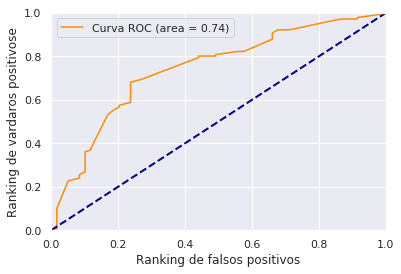

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=71, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [92]:
params = {}

params1={
    'n_estimators':3000,
    'objective': 'binary:logistic',
    'learning_rate': 0.01,
    #'gamma':0.1,
    #'subsample':0.8,
    #'colsample_bytree':0.3,
    #'min_child_weight':3,
    'max_depth':3,
    #'seed':1024,
    'n_jobs' : -1
}

xgbclf(params,X_train_clean_res[importance_col], y_train_clean_res,X_test_clean[importance_col], y_test_clean)

### GridSearchCV 
Esto lo que hace es buscar el mejor modelo que pasandole multipes parametros de entrada.

In [93]:
from sklearn.model_selection import GridSearchCV

print('XGBoost with grid search')
# play with these params
params={
    'learning_rate': [0.01, 0.02],
    'max_depth': [3], # 5 is good but takes too long in kaggle env
    #'subsample': [0.6], #[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    #'colsample_bytree': [0.5], #[0.5,0.6,0.7,0.8],
    'n_estimators': [50, 100, 200, 300, 400, 500]
    #'reg_alpha': [0.03] #[0.01, 0.02, 0.03, 0.04]
}


xgb_clf = xgb.XGBClassifier()

rs = GridSearchCV(xgb_clf,
                  params,
                  cv=2,
                  scoring="roc_auc",
                  n_jobs=1,
                  verbose=False)
rs.fit(X_train_clean_res[importance_col], y_train_clean_res)
best_est = rs.best_estimator_
print(best_est)

# Test 
print(rs.score(X_test_clean[importance_col],y_test_clean))



XGBoost with grid search
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
0.8660289042040731
0.7298954201226108


<a id="Others"></a> <br>
# 5. Otros algorimos
- Lighgbm 
- LogisticRegression 
- RandomForestClassifier 
- ExtraTreesClassifier 
- DecisionTreeClassifier
- GradientBoostingClassifier 
- AdaBoostClassifier

### Lighgbm


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0) 



/home/xus/PycharmProjects/machine-learning/venv/lib/python3.5/site-packages/matplotlib/legend.py:497: UserWarning: Unrecognized location "Arriva izquierda". Falling back on "best"; valid locations are
	center right
	upper center
	lower right
	upper right
	center
	lower left
	upper left
	best
	lower center
	right
	center left

  % (loc, '\n\t'.join(self.codes)))


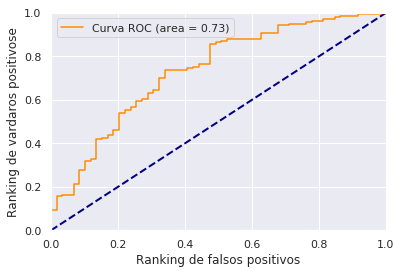

In [94]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import lightgbm as lgb

def lgbclf(X_train, y_train,X_test, y_test):

    model = lgb.LGBMClassifier().fit(X_train, y_train)
    print(model,'\n')

    # Predecimos 
    y_pred = model.predict_proba(X_test)[:,1]

    # Utilizamos la validazion cruzada.

    get_roc (y_test,y_pred)
    return

# Regrasion Logistica
#lgbclf(X_train, y_train,X_test,y_test)
lgbclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### LogisticRegression 

LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 



/home/xus/PycharmProjects/machine-learning/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


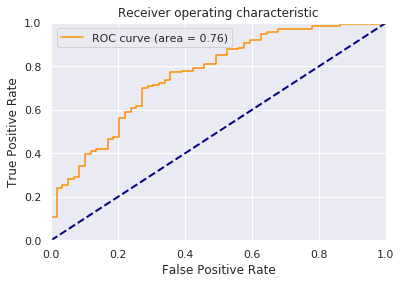

In [50]:
from sklearn.linear_model import LogisticRegression


def logregclf(X_train, y_train,X_test, y_test):
    print("LogisticRegression")
    model = LogisticRegression().fit(X_train, y_train)
    print(model,'\n')

    # Predecimos
    y_pred = model.predict_proba(X_test)[:,1]

   # Utilizamos la validazion cruzada.
    #get_eval(model, X_train, y_train,y_test,y_pred)
    #get_eval2(model, X_train, y_train,X_test, y_test,y_pred)
    get_roc (y_test,y_pred)
    return

# Logistic Regression
#logregclf(X_train, y_train,X_test,y_test)
logregclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### RandomForest 

RandomForestClassifier
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) 



/home/xus/PycharmProjects/machine-learning/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


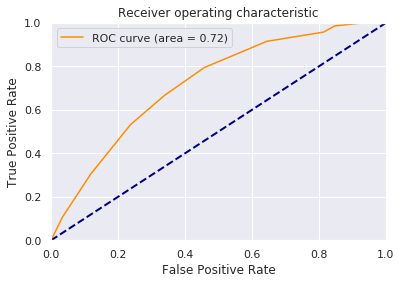

In [51]:
from sklearn.ensemble import RandomForestClassifier 

def randomforestclf(X_train, y_train,X_test, y_test):
    print("RandomForestClassifier")
    randomforest = RandomForestClassifier().fit(X_train, y_train)
    print(randomforest,'\n')
    
    # Predict target variables y for test data
    y_pred = randomforest.predict_proba(X_test)[:,1]

    # Utilizamos la validazion cruzada.
    #get_eval(randomforest, X_train, y_train,y_test,y_pred)
    get_roc (y_test,y_pred)
    return

# Random Forest
# Elegimos el arbol mas robusto
randomforestclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### ExtraTreesClassifier (ROC_AUC:0.74)

ExtraTreesClassifier
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False) 



/home/xus/PycharmProjects/machine-learning/venv/lib/python3.5/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


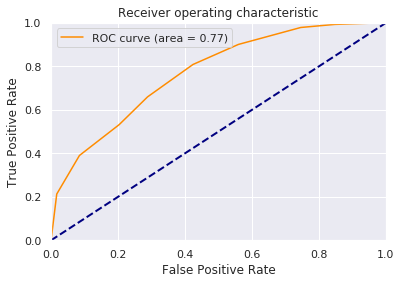

In [53]:
from sklearn.ensemble import ExtraTreesClassifier

def extratreesclf(X_train, y_train,X_test, y_test):
    print("ExtraTreesClassifier")
    extratrees = ExtraTreesClassifier().fit(X_train, y_train)
    print(extratrees,'\n')
    
    # Predecimos 
    y_pred = extratrees.predict_proba(X_test)[:,1]

    # Utilizamos la validazion cruzada.
    #get_eval(extratrees, X_train, y_train,y_test,y_pred)
    
    get_roc (y_test,y_pred)
    return
 
# Elegimos muchos arblos y elegimos el mas robusto
# Choose clean data, as tree is robust
extratreesclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### DecisionTreeClassifier (ROC_AUC:0.64)

DecisionTreeClassifier
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best') 



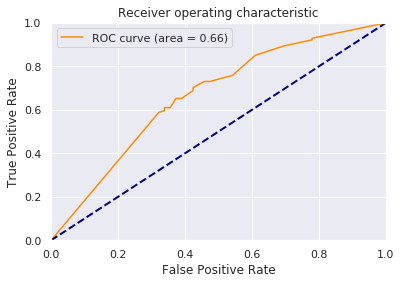

In [52]:
from sklearn.tree import DecisionTreeClassifier 
def dectreeclf(X_train, y_train,X_test, y_test):
    print("DecisionTreeClassifier")
    dec_tree = DecisionTreeClassifier(min_samples_split=10,min_samples_leaf=5).fit(X_train, y_train)
    print(dec_tree,'\n')
    
    y_pred = dec_tree.predict_proba(X_test)[:,1]

    
    # Utilizamos la validazion cruzada.
    #get_eval(dec_tree, X_train, y_train,y_test,y_pred)
    get_roc (y_test,y_pred)
    return

# Arbol de decision
dectreeclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### GradientBoostingClassifier (ROC_AUC:0.76)

GradientBoostingClassifier
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False) 



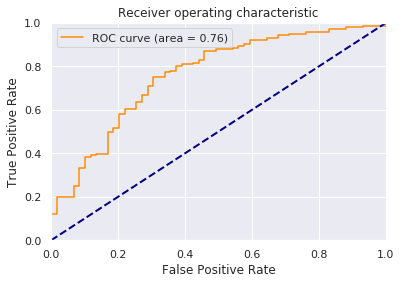

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

# fit, train and cross validate GradientBoostingClassifier with training and test data 
def gradientboostingclf(X_train, y_train, X_test, y_test):  
    print("GradientBoostingClassifier")
    gbclf = GradientBoostingClassifier().fit(X_train, y_train)
    print(gbclf,'\n')
    
    y_pred = gbclf.predict_proba(X_test)[:,1]

    # Utilizamos la validazion cruzada.
    #get_eval(gbclf, X_train, y_train,y_test,y_pred)
    get_roc (y_test,y_pred)
    return
  
# GradientBoostingClassifier
# Choose clean data, as tree is robust
gradientboostingclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

### AdaBoostClassifier (ROC_AUC:0.75)

AdaBoostClassifier
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None) 



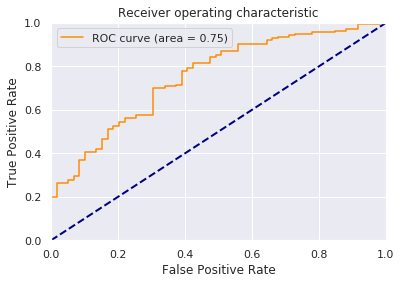

In [78]:
from sklearn.ensemble import AdaBoostClassifier


def adaboostclf(X_train, y_train, X_test, y_test):  
    print("AdaBoostClassifier")
    abclf = AdaBoostClassifier().fit(X_train, y_train)
    print(abclf,'\n')
    
    y_pred = abclf.predict_proba(X_test)[:,1]

    get_roc (y_test,y_pred)
    return

adaboostclf(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

SVMClassifier
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False) 



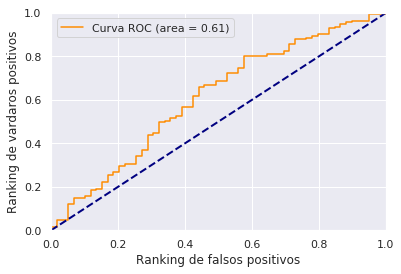

In [107]:
from sklearn import svm


def svmClassifier(X_train, y_train, X_test, y_test):  
    print("SVMClassifier")
    svModel = svm.SVC(gamma='scale', probability=True,decision_function_shape='ovr')
    svclf = svModel.fit(X_train, y_train)
    print(svclf,'\n')
    
    y_pred = svclf.predict_proba(X_test)[:,1]
    
    get_roc (y_test,y_pred)
  
    return




svmClassifier(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

BagClassifier


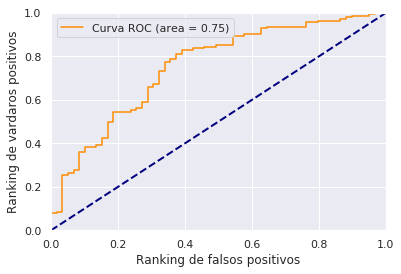

[0.73177116 0.20667673 0.9096774  0.32303998 0.38400893 0.25075455
 0.58760349 0.70417308 0.9951425  0.72433958 0.2266367  0.39675555
 0.73469929 0.9643117  0.56776542 0.71590114 0.95096284 0.93981374
 0.85735946 0.48146665 0.54103425 0.30272732 0.76186575 0.6707103
 0.98038835 0.77462523 0.42213627 0.98262678 0.89818728 0.24515735
 0.60543338 0.78988354 0.42857367 0.79293118 0.82298759 0.31300484
 0.85007243 0.38218848 0.62403279 0.81184506 0.60210535 0.4724546
 0.99589646 0.48615654 0.69982471 0.98605574 0.77326738 0.49081009
 0.93848566 0.90197709 0.69754815 0.69592036 0.28142356 0.3481078
 0.33637447 0.85288702 0.2141834  0.5374308  0.96320726 0.66495237
 0.37899816 0.99928571 0.31463674 0.97216595 0.4594437  0.48606946
 0.6487791  0.97564045 0.21011656 0.33535642 0.88377162 0.8958835
 0.97726462 0.51307391 0.63242922 0.62198678 0.54737155 0.88352286
 0.98799201 0.97354447 0.80601927 0.97909524 0.88825378 0.84704461
 0.20438    0.41321296 0.6002151  0.7186613  0.23537504 0.98898918

In [118]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier


def bagClassifier(X_train, y_train, X_test, y_test):  
    bBmodel = DecisionTreeClassifier(min_samples_split=10,min_samples_leaf=5)
    
    print("BagClassifier")
    bagModel =  BaggingClassifier(base_estimator=bBmodel, n_estimators=200, random_state=1023)
    bagclf = bagModel.fit(X_train, y_train)
    y_pred = bagclf.predict_proba(X_test)[:,1]
    get_roc (y_test,y_pred)
    print(y_pred)
    return




bagClassifier(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)

SVMClassifier
Iteration 1, loss = inf
Iteration 2, loss = 0.76836001
Iteration 3, loss = 0.79542062
Iteration 4, loss = 0.81236329
Iteration 5, loss = 0.82185959
Iteration 6, loss = 0.82683487
Iteration 7, loss = 0.82920812
Iteration 8, loss = 0.83019857
Iteration 9, loss = 0.83041176
Iteration 10, loss = 0.83025826
Iteration 11, loss = 0.82990588
Iteration 12, loss = 0.82947122
Iteration 13, loss = 0.82897114
Training loss did not improve more than tol=0.000010 for 10 consecutive epochs. Stopping.
MLPClassifier(activation='relu', alpha=0.1, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 2), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=21, shuffle=True, solver='sgd', tol=1e-05,
              validation_fraction=0.1, verbose=10, warm_start=False) 

[0.405

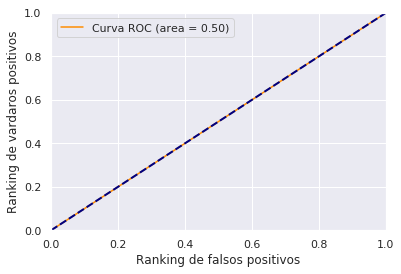

In [122]:
from sklearn.neural_network import MLPClassifier

def nnClassifier(X_train, y_train, X_test, y_test):  
    print("SVMClassifier")
    nnModel = MLPClassifier(hidden_layer_sizes=(10,2), max_iter=200, alpha=0.1,
                     solver='sgd', verbose=10,  random_state=21,tol=0.00001)
    nnclf = nnModel.fit(X_train, y_train)
    print(nnclf,'\n')

    y_pred = nnclf.predict_proba(X_test)[:,1]
    
    print(y_pred)
    get_roc (y_test,y_pred)

  
    return




nnClassifier(X_train_clean_res, y_train_clean_res,X_test_clean, y_test_clean)